In [8]:
! pip install transformers

  Using cached charset_normalizer-3.3.2-cp311-cp311-win_amd64.whl.metadata (34 kB)
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.5 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.5 MB 885.6 kB/s eta 0:00:11
   --- ------------------------------------ 0.8/9.5 MB 1.0 MB/s eta 0:00:09
   ---- ----------------------------------- 1.0/9.5 MB 1.0 MB/s eta 0:00:09
   ----- ---------------------------------- 1.3/9.5 MB 1.0 MB/s eta 0:00:08
   ------ --------------------------------- 1.6/9.5 MB 1.1 MB/s eta 0:00:08
   ------ --------------------------------- 1.6/9.5 MB 1.1 MB/s eta 0:00:08
   ------- -------------------------------- 1.8/9.5 MB 1.0 MB/s eta 0:00:08
   -------- ------------------------------- 2.1/9.5 MB 1.1 MB/s eta 0:00:07
   --------- ------------------------------ 2.4/9.5 MB 1.1 MB/s eta 0:00:07
   ----------- ---------

In [10]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm
# Read the CSV file with a different encoding
df = pd.read_csv(r"C:\Users\haris\Desktop\imp\masters\Research\done\Finance-sentiment_analysis_with_sir\res\finalized_4_models\FINAL_BERT_RESEARCH\data.csv", names=["sentence", 'sentiment'], encoding='ISO-8859-1')

# df=messages=pd.read_csv('data.csv',names=["sentence",'sentiment'])
print(df.head())

sentiment_map = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}
df['sentiment'] = df['sentiment'].map(sentiment_map)

# Drop rows with NaN values in the 'sentiment' column
df = df.dropna(subset=['sentiment'])


# Apply the mapping to the 'sentiment' column in the DataFrame
df['sentiment'] = df['sentiment'].astype(int)
print(df.head())


                                            sentence sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
3  According to the Finnish-Russian Chamber of Co...   neutral
4  The Swedish buyout firm has sold its remaining...   neutral
                                            sentence  sentiment
0  The GeoSolutions technology will leverage Bene...          2
1  $ESI on lows, down $1.50 to $2.50 BK a real po...          0
2  For the last quarter of 2010 , Componenta 's n...          2
3  According to the Finnish-Russian Chamber of Co...          1
4  The Swedish buyout firm has sold its remaining...          1


In [11]:



# Define your custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.loc[idx, 'sentence']
        label = self.dataframe.loc[idx, 'sentiment']
        encoding = self.tokenizer(text,
                                  add_special_tokens=True,
                                  max_length=self.max_len,
                                  truncation=True,
                                  padding='max_length',
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_classes = len(df['sentiment'].unique())
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

batch_size = 8
max_len = 128
num_epochs = 4
learning_rate = 2e-5

dataset = CustomDataset(dataframe=df, tokenizer=tokenizer, max_len=max_len)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batches'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    print(f'Average training loss: {avg_train_loss}')

    # Validation
    model.eval()
    val_loss = 0
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)

#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
#             loss = outputs.loss
#             val_loss += loss.item()

#             _, preds = torch.max(outputs.logits, dim=1)
#             num_correct += (preds == labels).sum().item()
#             num_samples += labels.size(0)

#     avg_val_loss = val_loss / len(val_loader)
#     val_accuracy = num_correct / num_samples
#     print(f'Average validation loss: {avg_val_loss}, Validation accuracy: {val_accuracy}')

#     # Update the learning rate
#     scheduler.step()

# print('Training complete!')

# # Save the model after training
# # torch.save(model.state_dict(), 'bert_modelll.pth')


c:\Users\haris\anaconda3\envs\college\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\haris\anaconda3\envs\college\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this w

Average training loss: 0.593934162094807


Epoch 2/4: 100%|██████████| 585/585 [01:48<00:00,  5.39batches/s]


Average training loss: 0.32803501452550166


Epoch 3/4: 100%|██████████| 585/585 [01:25<00:00,  6.83batches/s]


Average training loss: 0.22820769718203407


Epoch 4/4:  13%|█▎        | 74/585 [00:09<01:06,  7.68batches/s]

In [ ]:
# model_path = '/content/drive/My Drive/Final_Bert/bert_model.pth'
# tokenizer_path = '/content/drive/My Drive/Final_Bert/bert_tokenizer'

# # Save the model state_dict
# torch.save(model.state_dict(), model_path)

# # Save the tokenizer
# tokenizer.save_pretrained(tokenizer_path)

In [ ]:
# from transformers import BertForSequenceClassification, BertTokenizer

# # Assume that model and tokenizer are already fine-tuned and initialized
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# # Save model weights
# model.save_pretrained("/content/drive/MyDrive/Final_Bert")

# # Save model configuration
# model.config.save_pretrained("/content/drive/MyDrive/Final_Bert")

# # Save tokenizer configuration
# tokenizer.save_pretrained("/content/drive/MyDrive/Final_Bert")


In [ ]:
from transformers import BertForSequenceClassification
import torch

# Assuming labels are integers and stored in `num_classes`
num_classes = len(df['sentiment'].unique())

# Load the model architecture
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# Define the path to the saved model
model_path = '/content/drive/MyDrive/Final_Bert/bert_model.pth'

# Load the model state dictionary
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))


# Set the model to evaluation mode
model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# from transformers import BertForSequenceClassification

# num_classes = len(df['sentiment'].unique())  # Assuming labels are integers

# model_path = '/content/drive/MyDrive/Final_Bert/bert_model.pth'
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

# # Load the model checkpoint onto the CPU
# model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
# model.eval()  # Set the model to evaluation mode


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
#new_sentence_pos="The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model ."
new_sentence_pos = "The company reported larger than expected earnings for the quarter, leading to a surge in stock prices."

new_sentence_neg = "The company reported lower than expected earnings for the quarter, leading to a drop in stock prices."
#new_sentence_neg = "$ESI on lows, down $1.50 to $2.50 BK a real possibility"

new_sentence_neut = "The company announced its quarterly earnings report."
#new_sentence_neut ="Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEMENT 7.2.2007 at 10.30 A total of 56,955 new shares of Ahlstrom Corporation have been subscribed with option rights under the company 's stock option programs I 2001 and II 2001 ."
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

inputs = tokenizer(new_sentence_neg, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)

0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


inputs = tokenizer(new_sentence_pos, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)

2


In [ ]:
inputs = tokenizer(new_sentence_neut, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
print(predicted_label)

1


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, pipeline
import torch

# Set up the few-shot pipeline
def create_few_shot_pipeline(modelll):
    # Load the fine-tuned BERT model
    # model = BertForSequenceClassification.from_pretrained(model_path)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    few_shot_pipeline = pipeline(
        task="text-classification",
        model=modelll,
        tokenizer=tokenizer
    )

    return few_shot_pipeline

# Define the path to your fine-tuned BERT model
# model_path = "/content/drive/MyDrive/Final_Bert"

# Create the few-shot pipeline with your fine-tuned model
few_shot_pipeline = create_few_shot_pipeline(model)

# Define your few-shot texts and labels for training
few_shot_texts = [
    "The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .",
    "Ahlstrom Corporation STOCK EXCHANGE ANNOUNCEMENT 7.2.2007 at 10.30 A total of 56,955 new shares of Ahlstrom Corporation have been subscribed with option rights under the company 's stock option programs I 2001 and II 2001 .",
    "$ESI on lows, down $1.50 to $2.50 BK a real possibility"
                  ]
few_shot_labels = ["Positive", "Neutral","Negative"]  # Adjust labels accordingly

# Train the pipeline with your few-shot data
#
#########################################################
################ to  stop overfittinng ####################
############################################################
# for text, label in zip(few_shot_texts, few_shot_labels):
#     few_shot_pipeline(text)
#
#
#
#
# Ask the user for input and predict
user_input = input("Enter a statement: ")

result = few_shot_pipeline(user_input)

# Extract the predicted label from the result
predicted_label = result[0]['label']
predicted_score = result[0]['score']

print("Predicted label:", predicted_label)
print("Predicted score:", predicted_score)
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}

predicted_sentiment = label_map.get(predicted_label, "Unknown")
print("Predicted sentiment:", predicted_sentiment)



Enter a statement: hi
Predicted label: LABEL_2
Predicted score: 0.7647318243980408
Predicted sentiment: Positive


In [ ]:
# # Define the path to save the model (including the filename with the .pth extension)
# save_model_path = "/content/drive/MyDrive/Final_Bert/fewshoted_model.pth"

# # Save the model's state_dict() to a .pth file
# torch.save(model.state_dict(), save_model_path)


In [ ]:
# # Define the directory path where you want to save your model
# save_model_path = "/content/drive/MyDrive/Final_Bert/Final_Bert_fewshot"

# # Save the model and tokenizer (optional) using the save_pretrained() method
# model.save_pretrained(save_model_path)


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_classes = len(df['sentiment'].unique())  # Assuming labels are integers

model_path = '/content/drive/MyDrive/Final_Bert/fewshoted_model.pth'
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model.eval()  # Set the model to evaluation mode


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import pandas as pd

# Define a list to store data
data = []

# Evaluate the model on the validation dataset and store data
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Assuming labels are also tensors

        # Move model to the same device as input tensors
        model = model.to(device)

        # Make predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        # Append data to the list
        for i, label in enumerate(labels):  # Iterate over labels directly
            true_label = label.item()
            predicted_label = preds[i].item()
            data.append((true_label, predicted_label))

# Create a DataFrame
df_validation = pd.DataFrame(data, columns=['True Label', 'Predicted Label'])

# Display the DataFrame
print(df_validation)

# Save the DataFrame to a CSV file
df_validation.to_csv('your_file.csv', index=False)  # index=False prevents writing row indices


      True Label  Predicted Label
0              1                1
1              1                1
2              2                2
3              2                2
4              1                1
...          ...              ...
1164           1                1
1165           1                1
1166           1                1
1167           0                1
1168           1                1

[1169 rows x 2 columns]


In [ ]:
import os

# Define the directory where you want to save the CSV file
save_directory = '/content/drive/MyDrive/Final_Bert'

# Ensure the directory exists, create it if necessary
os.makedirs(save_directory, exist_ok=True)

# Define the file path
csv_file_path = os.path.join(save_directory, 'your_file.csv')

# Save the DataFrame to a CSV file
df_validation.to_csv(csv_file_path, index=False)  # index=False prevents writing row indices

print(f"CSV file saved to: {csv_file_path}")


CSV file saved to: /content/drive/MyDrive/Final_Bert/your_file.csv


# Overall Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# Assuming you have loaded your dataset into a pandas DataFrame
# Replace 'data.csv' with the path to your actual dataset
df = pd.read_csv(r"/content/drive/MyDrive/Final_Bert/your_file.csv")

# Extract true labels and predicted labels from the DataFrame
true_labels = df['True Label']
predicted_labels = df['Predicted Label']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1-score:", f1)




Accuracy: 0.8776732249786142
Precision: 0.8766332065974555
Recall: 0.8776732249786142
F1-score: 0.8771117412005065


# Confusion Matrix

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix


# Extract true labels and predicted labels from the DataFrame
true_labels = df['True Label']
predicted_labels = df['Predicted Label']

# Get unique labels
labels = sorted(set(true_labels) | set(predicted_labels))

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)

# Create a DataFrame for the confusion matrix with headers
confusion_df = pd.DataFrame(conf_matrix, index=['Actual ' + str(label) for label in labels], columns=['Predicted ' + str(label) for label in labels])
print("Confusion Matrix:")
print(confusion_df)


Confusion Matrix:
          Predicted 0  Predicted 1  Predicted 2
Actual 0          110           46            9
Actual 1           45          558           20
Actual 2            5           18          358


# Evaluation-Positive class

In [ ]:
# Calculate the index for the positive class
positive_class_index = labels.index(2)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for +ve class:", accuracy_positive)
print("Recall for +ve class:", recall_positive)
print("Precision for +ve class:", precision_positive)
print("F1-score for +ve class:", f1_positive)


Accuracy for +ve class: 0.9555175363558597
Recall for +ve class: 0.9396325459317585
Precision for +ve class: 0.9250645994832042
F1-score for +ve class: 0.9322916666666666


# Evaluation-Neutral class

In [ ]:
# Calculate the index for the positive class (class 1)
positive_class_index = labels.index(1)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive

# Calculate true negatives for the positive class (considering classes 0 and 2 as negative)
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for neutral class (1):", accuracy_positive)
print("Recall for neutral class (1):", recall_positive)
print("Precision for neutral class (1):", precision_positive)
print("F1-score for neutral class (1):", f1_positive)


Accuracy for neutral class (1): 0.8896492728828058
Recall for neutral class (1): 0.8956661316211878
Precision for neutral class (1): 0.8971061093247589
F1-score for neutral class (1): 0.8963855421686748


# Evaluation-Negative class

In [ ]:
# Calculate the index for the positive class (class 0)
positive_class_index = labels.index(0)

# Calculate true positives, false positives, false negatives for the positive class
tp_positive = conf_matrix[positive_class_index, positive_class_index]
fp_positive = conf_matrix[:, positive_class_index].sum() - tp_positive
fn_positive = conf_matrix[positive_class_index, :].sum() - tp_positive

# Calculate true negatives for the positive class (considering classes 1 and 2 as negative)
tn_positive = conf_matrix.sum() - (tp_positive + fp_positive + fn_positive)

# Calculate precision, recall, and F1-score for the positive class
precision_positive = tp_positive / (tp_positive + fp_positive)
recall_positive = tp_positive / (tp_positive + fn_positive)
f1_positive = 2 * (precision_positive * recall_positive) / (precision_positive + recall_positive)
accuracy_positive = (tp_positive + tn_positive) / (tp_positive + tn_positive + fp_positive + fn_positive)

# Print the scores for the positive class
print("Accuracy for class :", accuracy_positive)
print("Recall for class :", recall_positive)
print("Precision for class :", precision_positive)
print("F1-score for class 0 :", f1_positive)


Accuracy for class : 0.9101796407185628
Recall for class : 0.6666666666666666
Precision for class : 0.6875
F1-score for class 0 : 0.676923076923077


# ROC-AUC

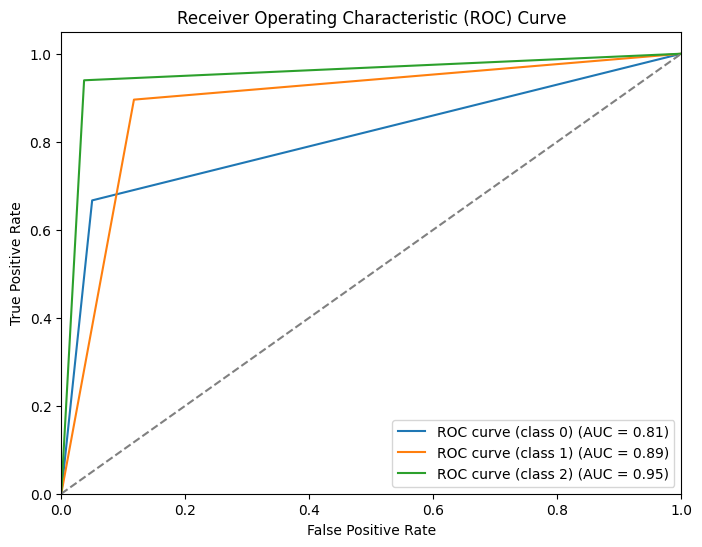

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute the ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, predicted_labels == i)
    roc_auc[i] = roc_auc_score(true_labels == i, predicted_labels == i)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



# Validation dataset-distribution

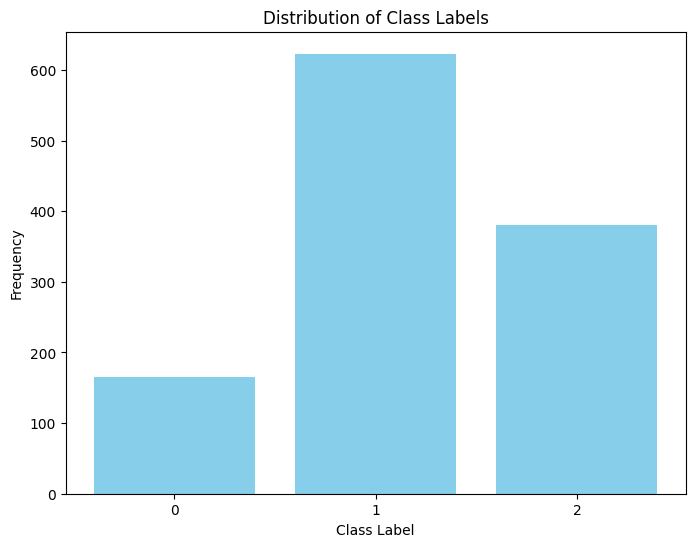

In [ ]:
import matplotlib.pyplot as plt

# Count the frequency of each class label
label_counts = df['True Label'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels')
plt.xticks(label_counts.index)  # Ensure all class labels are shown on the x-axis
plt.show()


# # complete dataset distribution

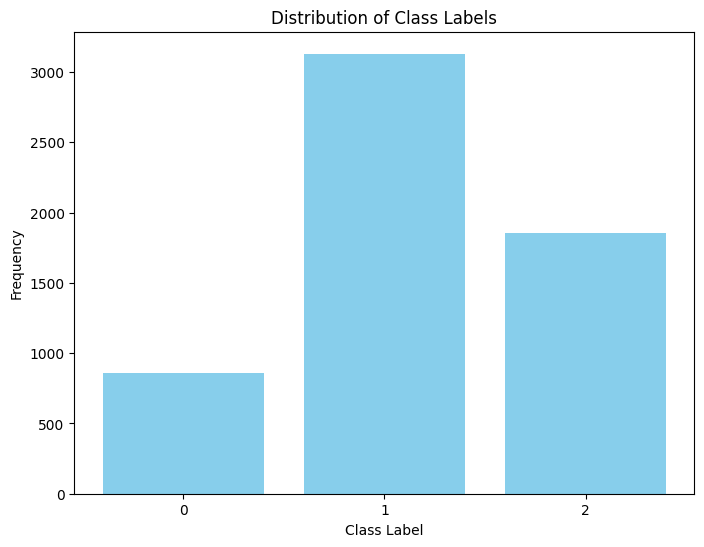

In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Read the CSV file with a different encoding
dff = pd.read_csv(r"/content/drive/MyDrive/Final_Bert/data.csv", names=["sentence", 'sentiment'], encoding='ISO-8859-1')

# Define the mapping for sentiment labels
sentiment_map = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}
dff['sentiment'] = dff['sentiment'].map(sentiment_map)

# Drop rows with NaN values in the 'sentiment' column
dff = dff.dropna(subset=['sentiment'])

# Apply the mapping to the 'sentiment' column in the DataFrame
dff['sentiment'] = dff['sentiment'].astype(int)


label_counts = dff['sentiment'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Class Labels')
plt.xticks(label_counts.index)  # Ensure all class labels are shown on the x-axis
plt.show()
